## Step 1: Query all recently annoated Corn images

In [1]:
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt, rcParams

import brtdevkit
from brtdevkit.core.db import DBConnector, DatetimeFilter
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter

from warnings import filterwarnings
filterwarnings("ignore")

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time



In [2]:
start = datetime(2021,3,29) # The first field was collected on 3/30/2021
end = datetime(2021, 10, 1)

filters = {"artifacts.kind": "nrg",
           "crop_name" : 'SOYBEANS', 
           'has_human_annotation': True
          }

soy_df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
soy_df['grower_farm_field'] = soy_df['grower'] + '_' + soy_df['farm'] + '_' + soy_df['operating_field_name']
print(f"Queried {len(soy_df)} images in {elapsed_time:.2f} s.")

Queried 10820 images in 15.29 s.


### Step 2: Remove any identical lat / long / camera_serial combinations

In [3]:
start_len = len(soy_df)
soy_df = soy_df.drop_duplicates(subset=['latitude', 'longitude', 'camera_serial'], keep='first')
print(f'{start_len - len(soy_df)} images were removed due to Identical Lat/Long/Camera_serial combos.')

545 images were removed due to Identical Lat/Long/Camera_serial combos.


In [4]:
soy_df.groupby('grower_farm_field').size()

grower_farm_field
Brandon Benton_King Ranch_Soybean Eastern field    120
Brandon Benton_King Ranch_Soybean Field            120
CA Skiles_Barton_3                                 239
CA Skiles_Barton_5                                 239
CG Davis_Sons 2 Farm_shop 40                       120
                                                  ... 
trais senter_airstrip_triton222                     99
trais senter_feedmill se_triton240                  86
travis senter_ron holthoise_burnt tractor           93
travis senter_ron holthouse_feedmill ne            101
travis senter_ron holthouse_w.gin.yd.1              99
Length: 153, dtype: int64

## Step 3: Check for Low Solar Angles

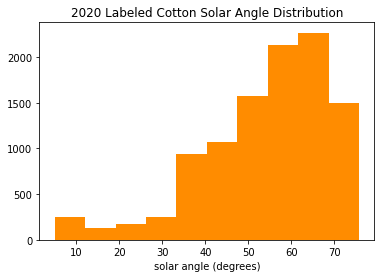

There are 0 soybean images from 0 fields with < 5 degree solar angles.


In [9]:
# Code to add solar_angle numbers to the dataframe

import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *

# You can instantiate the TimezoneFinder() oject inside the function if needed, but it will slow down the computation about 15%
tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

# apply to brtdevkit DataFrame with 'collected_on', 'latitude' and 'longitude' columns
soy_df['solar_angle'] = soy_df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)
plt.hist(soy_df['solar_angle'], color='darkorange')
plt.title('2020 Labeled Cotton Solar Angle Distribution')
plt.xlabel('solar angle (degrees)')
plt.show()

print(f'There are {len(soy_df[soy_df.solar_angle < 5])} soybean images from {len(soy_df[soy_df.solar_angle < 5].operating_field_name.unique())} fields with < 5 degree solar angles.')

## Step 4: Validate Annotations (most recent version, have s3_keys, etc)

In [97]:
# Flatten annotations to make them easily searchable

def flatten_annotations(dataframe):
    r = pd.DataFrame(
        {
            col:np.repeat(dataframe[col].values, dataframe['annotations'].str.len())
            for col in dataframe.columns.drop('annotations')
        }).assign(**{'annotations':np.concatenate(dataframe['annotations'].values)})[dataframe.columns]
    w = pd.concat([
        r.drop(['annotations'], axis=1),
        r['annotations'].apply(pd.Series).add_suffix('_annotations')
    ],
    axis=1)
    # Return filtered dataframe with each annotation artifact as a single row. 
    # Filter out ndvi and machine labels 
    return w[(w['kind_annotations'] != 'machine') & (w['kind_annotations'] != 'ndvi_mask')]

flat = flatten_annotations(soy_df)
print(f'There are {len(flat)} total annotations from {len(flat._id.unique())} unique image ids')

There are 25514 total annotations from 10275 unique image ids


In [98]:
# Reomove any annotations that have a more recent version (e.g. from an audit or correction)
# Remove any annotations that have a state other than 'ok'

flat = flat[(flat['state_annotations']=='ok') & (flat.next_version_annotations.isnull()==True)]
flat.next_version_annotations.isnull().value_counts()

True    7923
Name: next_version_annotations, dtype: int64

In [99]:
# Sort for the most recent annotations of each id
flat = flat.sort_values(by='created_at_annotations', ascending =True, axis=0)

# Romove any duplicate image ids
# annotations_final is now our master list of annotations used to create the annotation datasets
annotations_final = flat.drop_duplicates(subset=['_id'], keep='last')
print(f'There are {len(annotations_final)} annotated images that are valid.')

There are 7923 annotated images that are valid.


In [100]:
# Verify all annotations are pixelwise style 
annotations_final.style_annotations.value_counts()

pixelwise    7923
Name: style_annotations, dtype: int64

In [101]:
# Creating string versions of some metadata fields to be able to search through them. (There's probably a better way to do this)
annotations_final['nv'] = annotations_final.next_version_annotations.astype(str)
annotations_final['lm'] = annotations_final.label_map_annotations.astype(str)
annotations_final['s3k'] = annotations_final.s3_key_annotations.apply(str)
annotations_final['s3b'] = annotations_final.s3_bucket_annotations.apply(str)

# There are now no images with nans for label_map, s3_bucket and s3_key
print(len(annotations_final[(annotations_final['lm']== 'nan') | (annotations_final['s3k']== 'nan') | (annotations_final['s3b']== 'nan')]))
# There are no annotations with next_version is not null (meaning there is no newer version)
print(len(annotations_final[annotations_final.nv.isnull()==True]))

# This cell should output zeros and only one label map. Otherwise, there is something wrong. 
annotations_final['lm'].value_counts()

0
0


{'1': 'weed', '2': 'crop'}    7923
Name: lm, dtype: int64

In [102]:
# Look at which label policies were used

annotations_final['lp'] = annotations_final.label_policy_annotations.astype(str)

# cotton label policy is '6083224ccfbd2a9d788f2988'
# corn label policy is '607653583f4e7e93319cc306' 
# soy label policy is '608a9197e607efcba438d878'
# weed only label policy is '5f8a02ff6b7133e8cd0aac62'

print(annotations_final.lp.value_counts())

# Choose only the images with the correct labeling policy for soy. 
chosen_fields = annotations_final[annotations_final['lp']=='608a9197e607efcba438d878']
print(chosen_fields.lp.value_counts())

# all 2021 data is now in labels_2021 dataframe
labels_2021 = chosen_fields[['_id', 'grower','_id_annotations']]

608a9197e607efcba438d878    7738
5f8a02ff6b7133e8cd0aac62     148
607653583f4e7e93319cc306      36
6083224ccfbd2a9d788f2988       1
Name: lp, dtype: int64
608a9197e607efcba438d878    7738
Name: lp, dtype: int64


## Examine fields on map

In [103]:
# Examine Fields in Map to Ensure They are Unique
import folium

fields = chosen_fields.groupby('grower_farm_field').median().reset_index()[['grower_farm_field','latitude', 'longitude']]

# Generate base_map for adding points
def generateBaseMap(default_location=[36, -100], default_zoom_start=4.25):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()

# Add fields to the base_map
for i in range(len(fields)):
    folium.Marker(location=[fields.latitude[i], fields.longitude[i]],popup= fields.grower_farm_field[i]).add_to(base_map)

base_map

## Load 2020 + 2019 Datasets and merge with the new 2021 data

In [136]:
# Load 2020 datasets plus 

from brtdevkit.data import Dataset

# Retrieve 2020 datasets from Aletheia 
train_2019 = Dataset.retrieve(name = '062321_Soy_Train_2019').to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
all_folds_2020 =Dataset.retrieve(name = "Q42020_all_soy_qll_folds_annotation_10142020").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
holdout_2020 = Dataset.retrieve(name = "Q42020_all_soy_holdout_test_set_annotation_10142020").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
hq_test = Dataset.retrieve(name = 'Q42020_all_soy_inclusive_high_quality_v1').to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
problematic_ids = Dataset.retrieve(name = "20210621_test1").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]

### Remove Problematic IDs and HQ Test Images From Datasets

In [137]:
# We'll need to remove growers in 2019 train that are in 2020 test
remove_test_train_growers = ['Senter', 'Murry Henderson ','Jason stutts','Trey skiles', 'Robert Fann', 'Jeff Buyck', 'Todd Ochsner','John Jensen']
new_train_2019 = train_2019[~train_2019['grower'].isin(remove_test_train_growers)]
print(len(new_train_2019))

# Confirm there is no overlap between 2019 and 2020 datasets before merging
new_train_2019 = new_train_2019[~new_train_2019['annotation_pixelwise_0__id'].isin(all_folds_2020['annotation_pixelwise_0__id'])]
print(len(new_train_2019))
new_train_2019 = new_train_2019[~new_train_2019['annotation_pixelwise_0__id'].isin(holdout_2020['annotation_pixelwise_0__id'])]
print(len(new_train_2019))

6197
6197
6197


In [185]:
# concat 2019 train and 2020 train
revised_train = pd.concat([new_train_2019, all_folds_2020], axis=0)
print(len(revised_train))

# Remove problematic ids and hq_test images
revised_train = revised_train[~revised_train['id'].isin(problematic_ids['id'])]
print(len(revised_train))
revised_train = revised_train[~revised_train['id'].isin(hq_test['id'])]
print(len(revised_train))

87310
87310
85249


In [186]:
# confirm removal (should output 0s)
print(len(revised_train[revised_train['id'].isin(hq_test['id'])]))
print(len(revised_train[revised_train['id'].isin(problematic_ids['id'])]))

0
0


### Create Splits and Incorporate pre-2021 Data

Use 2021 data (labels_2021) to create new splits in the order:
* Dev set (all 2021 Data) - 10% of total data
* Test set (holdout 2020 + some 2021 data) - 20% of total data
* Train set (2019 + 2020 + any leftover 2021 data) - around 70% of total data

In [187]:
# fix grower names: Some growers have multiple entries usually as a result of misspelling or capitalization
# Toaccurately split grower, across sets and across years, we need to map the duplicates to a single common value

fix_grower_names = {'Pual Burt': 'Paul Bert', 
                   'Schronk Agri' : 'Todd Schronk', 
                   'Steven Beakley' : 'Steven Beakly',
                   'Jeff Baize': 'Jeff Blaize',
                    'Chris Hajovsky':'Chris Hajovsky CLH Farms',
                   'Chris Hajovsky CLH farms': 'Chris Hajovsky CLH Farms',
                    'craigwarner' : 'craig warner',
                   'freddyblack': 'freddy black',
                   'jeremy Jack': 'jeremy jack',
                    'ronholthoue': 'ron holthouse',
                   'trais senter': 'travis senter', 
                    'austin allred':'allen allred', 
                    'allena allred':'allen allred',
                    'cg davis': 'CG Davis',
                   'keith scrader':'keith schrader',
                    'JeffBuyck':'Jeff Buyck',
                    'Buyck Farms':'Jeff Buyck',
                    'jeff buyck':'Jeff Buyck',
                    'corn silk farms':'cornsilk farms',
                    'holthouse':'ron holthouse' ,
                    'holt house' : 'ron holthouse',
                    'holthousefarms': 'ron holthouse',
                    'd&l farms': 'D&L farms',
                    'D&L' : 'D&L farms',
                    'Dustin morris': 'Dustin Morris',
                    'dustin morris': 'Dustin Morris',
                    'Greenway': 'greenway coop',
                    'Eric Risad':'Eric Ristad',
                    'goodmam planting co llc':'goodman planting co', 
                    'JensenFarms': 'John Jensen',
                    'jensen': 'John Jenson',
                    'Jay norman':'Jay Norman',
                    'Johnny Jensen': 'John Jensen',
                    'john jensen': 'John Jensen',
                    'Mike Cor': 'Mike Cory',
                    'Senter': 'Travis Senter',
                    'Condrey Farms': 'Wade condrey',
                    'bluiver': 'blueriver',
                    'bluerive': 'blueriver',
                    'burton' : 'Burton',
                    'jepson fam farms':'jepson family farms',
                    'Andy': 'Andy Leighton',
                    'ken daulburg':'Ken Dalenburg',
                    'ken daulenburg':'Ken Dalenburg',
                    'Deere' : 'JDTIC',
                    'JeffBuyck': 'Jeff Buyck',
                    'dunn farms' : 'Clint Dunn',
                    'stephen fincher': 'Stephen Fincher',
                    'Henderson ':'murry henderson',
                    'murray hederson':'murry henderson',
                    'stutts bros':'stutts bros farms',
                    'hunter': 'hunter planting',
                    'travis senter': 'Travis Senter',
                    'jeremy jack':'Jeremy Jack',
                    'Jeff Erbes':'jeff erbes',
                    'nick vickers':'Nick Vickers',
                    'guetterman':'hayden guetterman',
                    'allen below':'Allen Below',
                    'Hunsinger':'paul hunsinger',
                    'bryan green':'Bryan Green',
                    'Nick Elser':'nick elser',
                    'hale bateman': 'Hal Bateman',
                    'jim buesing': 'Jim Buesing',
                    'brian brekken':'Brian Brekken',
                    'Brekken Farms': 'Brian Brekken',
                    'Nick Jorgensen ':'Nick Jorgenson',
                    'nick jorgenson': 'Nick Jorgenson',
                    'craig warner': 'Craig Warner',
                     'todd ochsner':  'Todd Ochsner',
                    'steve johnson': 'Steve Johnson',
                    'Johnson farms': 'Steve Johnson',
                    'ryan bergman':'Ryan Bergman',
                    'charile hammer': 'Charile Hammer',
                    'matt jones': 'Matt Jones',
                    'ryan luke': 'Ryan Luke',
                    'jeremy holscher':'Jeremy Holscher',
                     'condrey':'Wade condrey',
                    'fann farms':'Robert Fann',
                    'Douglas Nimz': 'Doug Nimz',
                    'craig paulek': 'Craig Paulek',
                    'andy':'Andy ISG',
                    'Jensen': 'John Jensen',
                    'howard mngnt':'john howard'
                   }

revised_train['grower'] = revised_train['grower'].map(fix_grower_names).fillna(revised_train['grower'])
print(f'After cleaning, there are {len(revised_train.grower.unique())} unique growers in the trainging set.')
holdout_2020['grower'] = holdout_2020['grower'].map(fix_grower_names).fillna(holdout_2020['grower'])
print(f'After cleaning, there are {len(holdout_2020.grower.unique())} unique growers in the 2020 test set.')
labels_2021['grower'] = labels_2021['grower'].map(fix_grower_names).fillna(labels_2021['grower'])
print(f'After cleaning, there are {len(labels_2021.grower.unique())} unique growers in the 2021 data.')

# Drops any of the same growers in train/test from the train set
revised_train = revised_train[~revised_train['grower'].isin(list(holdout_2020.grower.unique()))]

total_unique = len(set(list(labels_2021.grower.unique()) + list(holdout_2020.grower.unique()) + list(revised_train.grower.unique())))
print(f'We now have {total_unique} unique growers to split.')

After cleaning, there are 132 unique growers in the trainging set.
After cleaning, there are 29 unique growers in the 2020 test set.
After cleaning, there are 67 unique growers in the 2021 data.
We now have 197 unique growers to split.


In [191]:
# Now we need to assign the 2021 data into train/test/dev in 70/20/proportion, keeping the growers consistent between train/test

# 70% of 197 is 138
# 20% of 197 is 39
# 20% of 197 is 20

# rename columns to be consistent
labels_2021.columns = ['id','grower','annotation_id']
holdout_2020.columns = ['id','grower','annotation_id']
revised_train.columns = ['id','grower','annotation_id']

overlap_train = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())].grower.unique()
print(f'{len(overlap_train)} growers from 2021 are present in the train set')

overlap_test = labels_2021[labels_2021['grower'].isin(holdout_2020['grower'].unique())].grower.unique()
print(f'{len(overlap_test)} growers from 2021 are present in the test set')
all_growers_2020_2019 = list(holdout_2020['grower'].unique()) + list(revised_train['grower'].unique())

no_overlap = labels_2021[~labels_2021['grower'].isin(all_growers_2020_2019)].grower.unique()
print(f'{len(no_overlap)} growers from 2021 are not present in any older dataset')

22 growers from 2021 are present in the train set
7 growers from 2021 are present in the test set
38 growers from 2021 are not present in any older dataset


In [192]:
# Create Dev set from growers not present in the train or test datasets
# Number of growers is 20 or 10% of total
from random import shuffle
shuffle(no_overlap)

n_dev_growers = 20
dev_growers =  no_overlap[0:n_dev_growers]
no_overlap = no_overlap[n_dev_growers:]

dev_set = labels_2021[labels_2021['grower'].isin(dev_growers)]
print(f'There are {len(dev_set.grower.unique())} growers in the dev set and {len(dev_set)} labeled images.')
print(f'there are now {len(no_overlap)} growers still available')

There are 20 growers in the dev set and 2741 labeled images.
there are now 18 growers still available


In [193]:
# Create Test set

test_2021 = labels_2021[labels_2021['grower'].isin(holdout_2020['grower'].unique())]
final_test = pd.concat([holdout_2020, test_2021], axis=0)
still_needed = 39 - len(final_test.grower.unique())
print(f'We need {still_needed} more growers to get to 20%')
new_test_growers = no_overlap[0:still_needed]
no_overlap= no_overlap[still_needed:]
print(f'There are still {len(no_overlap)} growers available.')
#
final_test = pd.concat([final_test, labels_2021[labels_2021['grower'].isin(new_test_growers)]], axis=0)
len(final_test.grower.unique())

We need 10 more growers to get to 20%
There are still 8 growers available.


39

In [194]:
# Create Train Set

train_2021 = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())]

final_train = pd.concat([revised_train, train_2021], axis=0)

still_needed = 138 - len(final_train.grower.unique())
print(f'We need {still_needed} more growers to get to 70%')
new_train_growers = no_overlap[0:still_needed]
print(len(new_train_growers))
no_overlap= no_overlap[still_needed:]
print(f'There are now {len(no_overlap)} growers left over.')
final_train = pd.concat([final_train, labels_2021[labels_2021['grower'].isin(new_train_growers)]], axis=0)
len(final_train.grower.unique())

We need 8 more growers to get to 70%
8
There are now 0 growers left over.


138

### Check for leakage betwen 2020 and 2021

In [209]:
# Check for overlapping ids between new train and old test, new test and old train. Shoould output all zeros. 

print(len(final_train[final_train.id.isin(holdout_2020.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(revised_train.id.unique())].id.unique()))

0
0


In [210]:
# Check for any growers present in different sets. Should output all zeros

print(len(final_train[final_train.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(final_train[final_train.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(final_train.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_train.grower.unique())].grower.unique()))

0
0
0
0
0
0


In [211]:
# Check for any annotation_ids present in multiple sets. Should output all zeros

print(len(final_train[final_train.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(final_train[final_train.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))

0
0
0
0
0
0


In [197]:
# Check for any ids present in multiple sets. Should output all zeros

print(len(final_train[final_train.id.isin(final_test.id.unique())].id.unique()))
print(len(final_train[final_train.id.isin(dev_set.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(final_train.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(dev_set.id.unique())].id.unique()))
print(len(dev_set[dev_set.id.isin(final_test.id.unique())].id.unique()))
print(len(dev_set[dev_set.id.isin(final_train.id.unique())].id.unique()))

0
0
0
0
0
0


## Final Preparation Step: Create Lists and Verify

In [201]:
print(len(dev_set))
print(len(dev_set.grower.unique()))
dev_list = list(dev_set.annotation_id.astype(str))
print(len(dev_list))
dev_list[0:5]
#dev_set.head()

2741
20
2741


['609c5918500946cdd93008a1',
 '609c5918500946cdd93008b6',
 '609c5919500946cdd93008d7',
 '609c5919500946cdd9300913',
 '609c5919500946cdd930091f']

In [202]:
print(len(final_train))
print(len(final_train.grower.unique()))
train_list = list(final_train.annotation_id.astype(str))
print(len(train_list))
train_list[0:5]

87560
138
87560


['5df91c9280a73f861ba8b852',
 '5df91c9380a73f861ba8bcda',
 '5df91c9380a73f861ba8bd18',
 '5df91c9380a73f861ba8bd91',
 '5df91c9380a73f861ba8c1ba']

In [203]:
print(len(final_test))
print(len(final_test.grower.unique()))
test_list = list(final_test.annotation_id.astype(str))
print(len(test_list))
test_list[0:5]

24674
39
24674


['5eb8bfdfa89cc8ea323ca5a7',
 '5eb8bfdfa89cc8ea323ca5ae',
 '5eb8bfdfa89cc8ea323ca5b0',
 '5eb8bfdfa89cc8ea323ca5b4',
 '5eb8bfdfa89cc8ea323ca5b5']

## Finally, create the dataset

In [51]:
from brtdevkit.data import Dataset

# Enter a name and description
dataset_name= '062821_Soy_Train_v2'
description = 'Soy train dataset revised to omit the 1082 annotations from 2020 missing a NRG ID.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = ns
    )

{}

### Create Subsampled Test Set

In [45]:
# How I found and removed the problematic 
ns = list(test_soy[test_soy['artifact_nrg_0__id'].isna()==False]['annotation_pixelwise_0__id'])
ns[0:5]

['5df91c9280a73f861ba8b852',
 '5df91c9380a73f861ba8bcda',
 '5df91c9380a73f861ba8bd18',
 '5df91c9380a73f861ba8bd91',
 '5df91c9380a73f861ba8c1ba']

In [63]:
from brtdevkit.data import Dataset

lmx = Dataset.retrieve(name='070821_Cotton_Train_Set_v1').to_dataframe()

In [60]:
lmx.columns[0:30]

Index(['angle_to_row', 'annotation_pixelwise_0__cls',
       'annotation_pixelwise_0__id',
       'annotation_pixelwise_0_annotation_job_id',
       'annotation_pixelwise_0_audit_at', 'annotation_pixelwise_0_audit_by',
       'annotation_pixelwise_0_audit_mistakes',
       'annotation_pixelwise_0_audit_requested',
       'annotation_pixelwise_0_created_at',
       'annotation_pixelwise_0_is_active_version',
       'annotation_pixelwise_0_is_deleted', 'annotation_pixelwise_0_kind',
       'annotation_pixelwise_0_label_map',
       'annotation_pixelwise_0_label_policy',
       'annotation_pixelwise_0_labeled_objects',
       'annotation_pixelwise_0_mask_height',
       'annotation_pixelwise_0_mask_width',
       'annotation_pixelwise_0_next_version',
       'annotation_pixelwise_0_nothing_to_annotate',
       'annotation_pixelwise_0_prev_version',
       'annotation_pixelwise_0_promote_to_review',
       'annotation_pixelwise_0_review_reasons',
       'annotation_pixelwise_0_review_reque

In [64]:
lmx.annotation_pixelwise_0_next_version.isnull().value_counts()

True     67513
False      212
Name: annotation_pixelwise_0_next_version, dtype: int64

In [ ]:
60405b6d50a82cdef9be93e5    561
5eb48622e154067231d8121b    221
6083224ccfbd2a9d788f2988    128

In [23]:

under = []

vals = test_soy.grower_farm_field.value_counts().reset_index()
for m in range(len(vals)):
    if vals.grower_farm_field[m] <30:
        under.append(vals.iloc[m]['index'])
under

['JeffBuyck_Buyck Farms_Diamond T Lake Farm',
 'Kyle Patten_patten farms_Madson',
 'Kyle Patten_patten farms_Tony Peterson West',
 'Kyle Patten_patten farms_Gilette Grove',
 'ron holthouse_senter_river field',
 'jim buesing_buesings farm_83-spayer',
 'jim buesing_buesing farms_border',
 'ryan bergman_isu_airport',
 'jeff buyck_jeff buyck_diamond t home ne',
 'ryan bergman_isu_e bilsland',
 'charile hammer_hammer & kavazanjian_wh&w all',
 'jeff erbes_erbes farms_ehlers -1',
 'jeff erbes_erbes farms_genes 1/4',
 'jeff buyck_jeff buyck_diamond t n 1/4 west',
 'ron holthouse_sen_river field',
 'jeff buyck_jeff buyck_stans by emils',
 'ryan luke_luke farms_north of creek',
 'burton_burton_burton',
 'todd ochsner_tdo farms_133rd/375th east',
 'ryan luke_luke farms_south of creek',
 'jeff erbes_erbes farms_ewolds',
 'Kenny Twedt_Twedt Farms_home place',
 'ryan luke_luke farms_pond',
 'jim buesing_jkb farms_border 117ac',
 'todd ochsner_tdo farms_133rd and 375th',
 'matt krueger_k&d krueger fa

In [26]:
test_soy = test_soy[~test_soy['grower_farm_field'].isin(under)]
np.min(test_soy.grower_farm_field.value_counts())

30

In [27]:
from random import shuffle

sample_ids = []

#in the future when you upgrade to pandas 1.1 use this next line:
# sampled = test_corn.groupby("grower_farm_field").apply(sample(n=30, random_state=1))

for f in test_soy.grower_farm_field.unique():
    sub = test_soy[test_soy['grower_farm_field']==f]
    
    sub_id = list(sub['annotation_pixelwise_0__id'])
    shuffle(sub_id)
    sample_ids = sample_ids + (sub_id[0:30])

print(len(sample_ids))
print(len(test_soy.grower_farm_field.unique())*30)
sample_ids[0:5]

3420
3420


['5eba0d7a8d4eadb54de2256c',
 '5eb8bfdfa89cc8ea323ca5ba',
 '5ebbb161dce5a6025db81813',
 '5f6b610bc5743db4e98d7604',
 '5eb8bfdfa89cc8ea323ca5b0']

In [28]:
# Enter a name and description
dataset_name= '062921_Soy_Subsampled_Test_Set_v1'
description = 'A subsampled test set of 062821_Soy_Test_Set_v1, with 30 images randomly chosen per field.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = sample_ids
    )

{}